In [66]:
import numpy as np
from scipy import stats
import scipy.sparse as sparse
import argparse
import sys
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import datetime as dt
import pickle as pkl
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse

In [67]:
# load labels
label, rev_index, features = pkl.load(open("../../../data/feature_index_all.pkl", "rb"))
feature_size = len(features) + 384
test_data  = np.loadtxt("../../../data/Lindel_test_with_full_seqs.txt", delimiter='\t', dtype='str')
data = test_data[:, 1:].astype('float32')
y = data[:, feature_size:]

model_preq = pkl.load(open("../../../data/model_prereq.pkl", 'rb'))
label,rev_index,features,frame_shift = model_preq
# load pkle file with the predicted frameshifts and predictions for Random Forest
predicted_frameshift = pkl.load(open('../../../data/predicted_frameshift.pkl','rb'))
predictions = pkl.load(open('../../../data/predictions.pkl','rb'))
# normalize predictions
for i, p in enumerate(predictions):
    try:
        predictions[i] = p / np.sum(p)
    except:
        continue

# get the actual frameshifts
actual_frameshift = np.dot(y,frame_shift).tolist()

# plot the actual vs. predicted frameshifts    
for i, pfs in enumerate(predicted_frameshift): 
    if type(pfs) != np.float64:
        # remove the predicted frameshifts that are not floats
        predicted_frameshift.pop(i)
        actual_frameshift.pop(i)

mse = np.mean((np.array(actual_frameshift) - np.array(predicted_frameshift))**2)
mse = round(mse, 3)

# calculate pearson correlation
pearson = stats.pearsonr(actual_frameshift, predicted_frameshift)
# keep 3 decimal places
pearson = round(pearson[0], 3)


# calculate the mses
mses = []
# calculate MSEs
for i, prediction in enumerate(predictions):
    if type(prediction) == str  or type(prediction) != np.ndarray:
        continue
    mses.append(np.mean((prediction - y[i])**2))


In [68]:
mses_per_class = zip(label, np.array(mses)/10**-3)

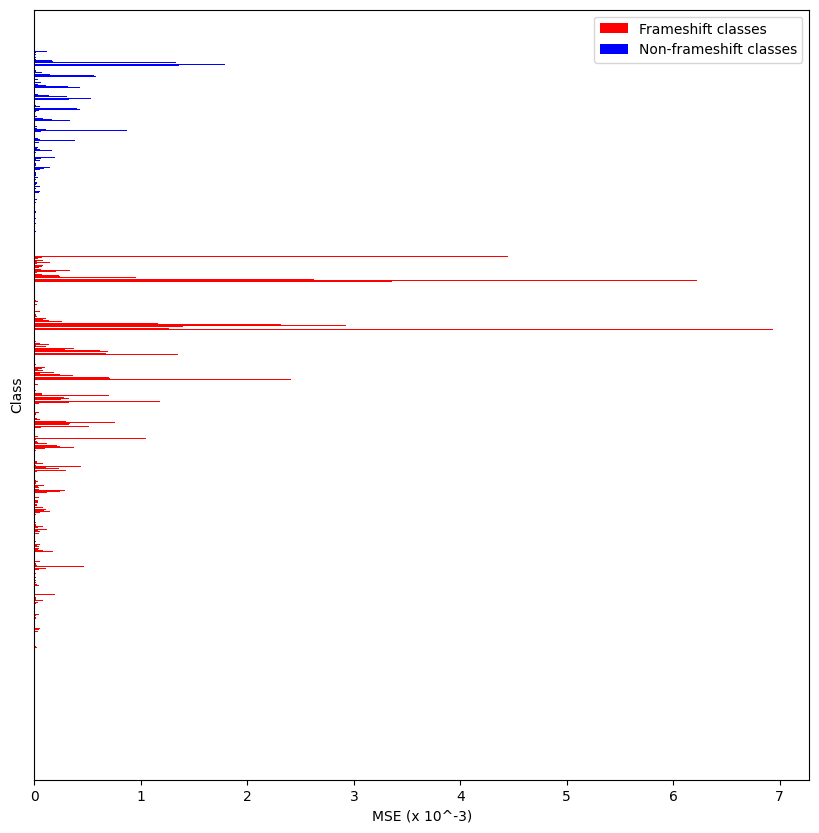

In [76]:
# filter classes that have microhomology

# get the microhomology classes
frameshift_classes =  dict()
non_frameshift_classes = dict()

for i, fm in enumerate(frame_shift):
    if fm != 0:
        frameshift_classes[rev_index[i]] = 0
        
        count = 0
        # calcualte the mse for this label where y[i] contains predictions per class
        for j, prediction in enumerate(predictions):
            if type(prediction) == str  or type(prediction) != np.ndarray:
                continue
            count += 1
            frameshift_classes[rev_index[i]] +=  (prediction[i] - y[j][i])**2


        # find mean
        frameshift_classes[rev_index[i]] = frameshift_classes[rev_index[i]] /count
        frameshift_classes[rev_index[i]] = frameshift_classes[rev_index[i]] / 10**-3
        
    else:
        non_frameshift_classes[rev_index[i]] = 0
        count = 0
        # calcualte the mse for this label where y[i] contains predictions per class
        for j, prediction in enumerate(predictions):
            if type(prediction) == str  or type(prediction) != np.ndarray:
                continue
            count += 1
            non_frameshift_classes[rev_index[i]] += (prediction[i] - y[j][i])**2
        
        # find mean
        non_frameshift_classes[rev_index[i]] = non_frameshift_classes[rev_index[i]] / count 
        non_frameshift_classes[rev_index[i]] = non_frameshift_classes[rev_index[i]] / 10**-3
        

# make a plot that shows both the frameshift and non-frameshift classes in one plot
plt.figure(figsize=(10, 10))
plt.barh(*zip(*frameshift_classes.items()), color='red', label='Frameshift classes')
plt.barh(*zip(*non_frameshift_classes.items()), color='blue', label='Non-frameshift classes')
plt.barh(*zip(*non_frameshift_classes.items()), color='blue')
plt.xlabel("MSE (x 10^-3)")
plt.legend()
plt.ylabel("Class")
# remove yticks
plt.yticks([])
plt.show()
plt.close()

In [80]:
model_preq = pkl.load(open("../../../data/model_prereq.pkl", 'rb'))
label,rev_index,features,frame_shift = model_preq
print(sum(frame_shift), len(label),  len(label) - sum(frame_shift))

389.0 557 168.0
